In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
train_dir = '/content/drive/MyDrive/disease_skin/train'
validation_dir = '/content/drive/MyDrive/disease_skin/validation'
test_dir = '/content/drive/MyDrive/disease_skin/test'

In [39]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

In [40]:
# Image size
img_size = (224, 224)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3]
)

In [41]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [42]:
# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Validation generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 299 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [43]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [44]:
# Load InceptionV3 with pretrained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the base model (more layers)
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.05))(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [45]:
# Custom focal loss function for multi-class classification
def focal_loss(gamma=2., alpha=4.):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (tf.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (tf.ones_like(y_true) - y_pred)
        fl = - alpha_t * tf.pow((tf.ones_like(y_true) - p_t), gamma) * tf.math.log(p_t)
        return tf.reduce_mean(fl)
    return focal_loss_fixed

In [46]:
# Compile the model with custom focal loss
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss=focal_loss(), metrics=['accuracy'])

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [47]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

# Training with class weights
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[LearningRateScheduler(lr_scheduler), early_stopping, reduce_lr]
)

Epoch 1/50
10/10 [==============================] - 43s 871ms/step - loss: 42.1661 - accuracy: 0.2676 - val_loss: 41.0487 - val_accuracy: 0.3600 - lr: 1.0000e-04
Epoch 2/50
10/10 [==============================] - 8s 826ms/step - loss: 41.0112 - accuracy: 0.4013 - val_loss: 40.2152 - val_accuracy: 0.5300 - lr: 1.0000e-04
Epoch 3/50
10/10 [==============================] - 8s 759ms/step - loss: 39.9940 - accuracy: 0.5886 - val_loss: 39.4534 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 4/50
10/10 [==============================] - 9s 925ms/step - loss: 39.1043 - accuracy: 0.6288 - val_loss: 38.7077 - val_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 5/50
10/10 [==============================] - 11s 1s/step - loss: 38.3522 - accuracy: 0.6789 - val_loss: 37.9645 - val_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 6/50
10/10 [==============================] - 8s 811ms/step - loss: 37.5499 - accuracy: 0.7090 - val_loss: 37.2024 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 7/50
10/10 [=================

In [48]:
# Evaluation on training set
train_loss, train_acc = model.evaluate(train_generator)
print(f'Training Accuracy: {train_acc * 100:.2f}%')

10/10 [==============================] - 7s 614ms/step - loss: 26.9401 - accuracy: 0.9565
Training Accuracy: 95.65%


In [49]:
# Evaluation on validation set
val_loss, val_acc = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

4/4 [==============================] - 1s 185ms/step - loss: 27.0325 - accuracy: 0.9100
Validation Accuracy: 91.00%


In [50]:
# Evaluation on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

4/4 [==============================] - 1s 200ms/step - loss: 28.5672 - accuracy: 0.5400
Test Accuracy: 54.00%


In [51]:
# Classification Report on test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

4/4 [==============================] - 3s 283ms/step
                                precision    recall  f1-score   support

               Kutil Molluscum       0.00      0.00      0.00        20
Kutil Tua (Keratosis Seboroik)       0.05      0.05      0.05        20
          Lesi Keratosis Jinak       1.00      1.00      1.00        20
                     Psoriasis       0.77      0.85      0.81        20
Ringworm (Kurap Infeksi Jamur)       0.89      0.80      0.84        20

                      accuracy                           0.54       100
                     macro avg       0.54      0.54      0.54       100
                  weighted avg       0.54      0.54      0.54       100



4/4 [==============================] - 2s 97ms/step


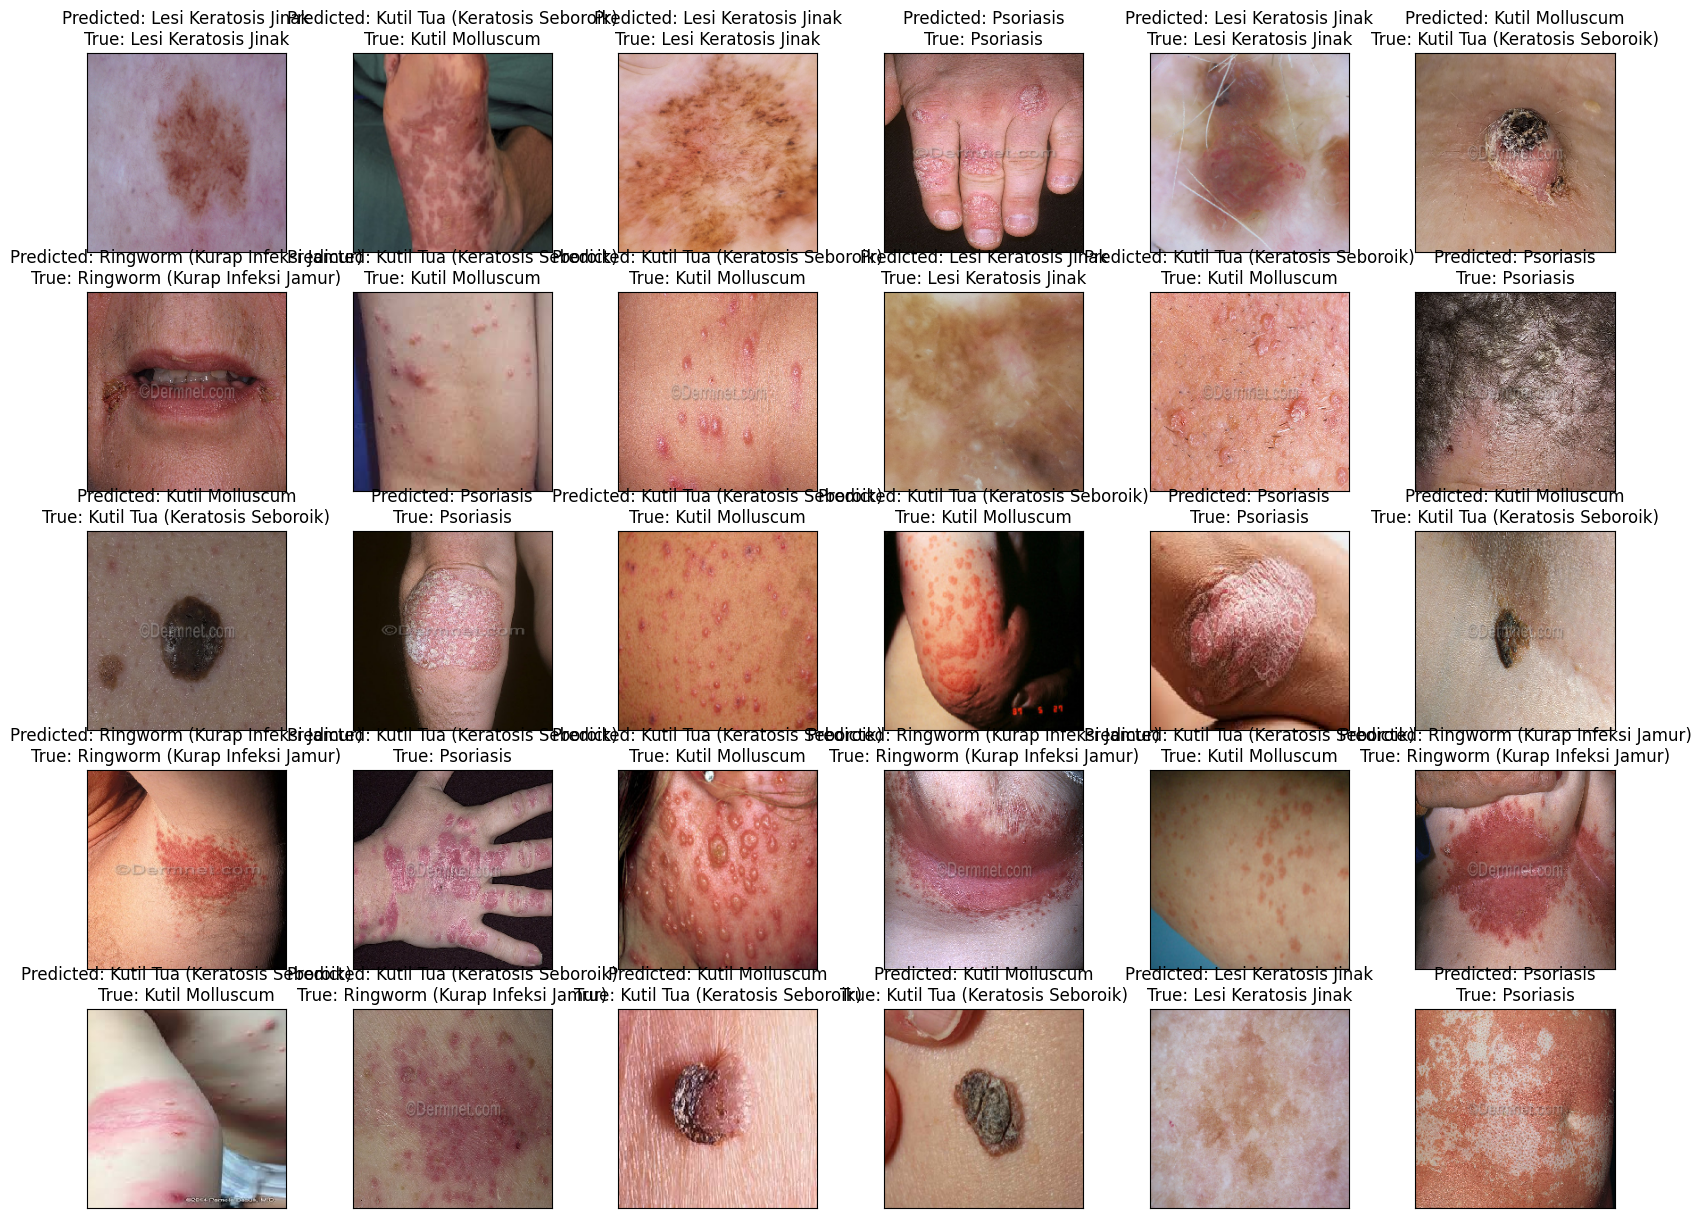

In [52]:
# Get all images and labels from test_generator
test_generator.reset()
X_test, y_test = [], []
for _ in range(len(test_generator)):
    x, y = test_generator.next()
    X_test.extend(x)
    y_test.extend(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Predict classes for test set
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# True classes for test set
true_classes = np.argmax(y_test, axis=1)

# Plot a random sample of test images, their predicted labels, and ground truth
# Number of samples to plot
num_samples = 30

# Get random sample of test indices
random_indices = np.random.choice(len(true_classes), size=num_samples, replace=False)

# Create figure
fig = plt.figure(figsize=(20, 15)) # Adjust the figure size to accommodate more images

for i, idx in enumerate(random_indices):
    ax = fig.add_subplot(5, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[idx])
    pred_label = class_labels[y_pred[idx]]
    true_label = class_labels[true_classes[idx]]
    ax.set_title(f"Predicted: {pred_label}\nTrue: {true_label}")

plt.show()

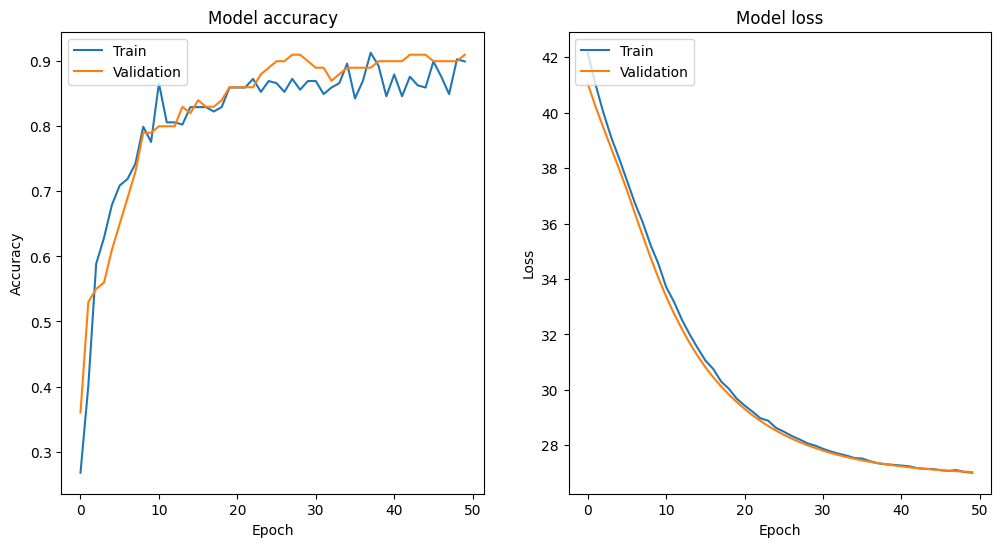

In [53]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [54]:
model.save('Model2_DermaOne.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
